In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, auc, ndcg_score
from tdescore.classifier.train import train_classifier
from tdescore.classifier.features import fast_host_columns, host_columns, infant_columns, week_columns, month_columns, get_thermal_columns, post_peak, parse_columns
from tdescore.lightcurve.thermal import THERMAL_WINDOWS
from tdescore.classifier.collate import get_classified_sources, convert_to_train_dataset
import matplotlib.patheffects as path_effects
import pandas as pd
from pathlib import Path
import shap
from tdescore.classifier.collate import convert_to_train_dataset
import joblib
pd.set_option('display.max_rows', 500)

In [2]:
logging.getLogger("tdescore").setLevel("INFO")

In [3]:
all_sources = get_classified_sources()

INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes


In [4]:
# all_features = [fast_host_columns, host_columns, early_columns, peak_columns, post_peak]
# labels = ["Host Only (Fast)", "Host Only", "Early", "Peak", "Full"]

sets = [
    ("Full", post_peak),
    ("Host Only (Fast)", fast_host_columns),
    ("Host Only", host_columns),
    ("Infant", infant_columns),
    ("Week", week_columns),
    ("Month", month_columns),
]

sets += [(f"Thermal_{x}", get_thermal_columns(x)) for x in THERMAL_WINDOWS]

all_features = [x[1] for x in sets]
labels = [x[0] for x in sets]

In [5]:
relevant_columns, column_descriptions = parse_columns(all_features[-1])
full_columns, full_descriptions = parse_columns(all_features[0])

In [6]:
non_nan_mask = np.ones(len(all_sources), dtype=bool)
for _, columns in sets:
    cols, _ = parse_columns(columns)
    data_to_use = convert_to_train_dataset(all_sources, columns=cols)
    non_nan_mask *= ~np.array([pd.isnull(x).sum() > 0 for x in data_to_use])
full_info_sources = all_sources[non_nan_mask].reset_index(drop=True)
full_info_sources

,ztf_name,crossmatch_bts_class,fritz_class,wise_w1w2,wise_w2w3,positive_fraction,det_peak_1,det_peak_2,det_peak_3,det_peak_all,...,has_milliquas,milliquas_score,milliquas_class,growth_n_spectra,growth_class,bts_class,class,subclass,class_origin,has_spectrum
0,ZTF17aaazdba,TDE,Tidal Disruption Event,-0.002,1.014,0.968037,15.276900,15.428100,NaN,15.276900,...,0,-1.0,None,25,TDE,TDE,True,TDE,TNS,True
1,ZTF17aabhjci,None,AGN,0.382,2.496,0.734783,16.666901,16.265499,16.813000,16.265499,...,1,S,ARX,0,AGN,None,False,AGN,Milliquas,False
2,ZTF17aacovcm,None,AGN,0.113,1.256,0.363636,17.724100,16.778099,NaN,16.778099,...,1,J,ARX,0,AGN,None,False,AGN,Milliquas,False
3,ZTF18aaabiea,None,AGN,1.018,2.744,0.507792,15.121800,14.586200,14.949900,14.586200,...,1,S,AR2,0,AGN,None,False,AGN,Milliquas,False
4,ZTF18aaaibml,SN II,IIP,0.281,4.031,0.956522,18.271700,18.260599,NaN,18.260599,...,0,-1.0,None,4,SN II,SN II,False,SN II,TNS,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,ZTF22aagyuao,TDE,Tidal Disruption Event,0.119,2.018,1.000000,16.430700,17.069000,17.386400,16.430700,...,0,-1.0,None,0,None,TDE,True,TDE,TNS,True
809,ZTF22aahhgue,SN Ia,Ia,999.000,999.000,1.000000,18.665300,18.707899,19.042000,18.665300,...,0,-1.0,None,0,SN Ia,SN Ia,False,SN Ia,TNS,True
810,ZTF22aahieds,SN Ia,Ia,-0.058,0.570,1.000000,18.354500,18.236099,18.282301,18.236099,...,0,-1.0,None,0,SN Ia,SN Ia,False,SN Ia,TNS,True
811,ZTF22aahnglu,duplicate,duplicate,0.105,2.963,1.000000,18.338900,17.386900,18.582100,17.386900,...,1,None,AR,0,None,None,False,AGN,Milliquas,False


In [7]:
for col in full_info_sources.columns:
    print(col)

ztf_name
crossmatch_bts_class
fritz_class
wise_w1w2
wise_w2w3
positive_fraction
det_peak_1
det_peak_2
det_peak_3
det_peak_all
raw_n_det
sgscore1
distpsnr1
distnr
chinr
drb
sharpnr
magdiff
classtar
nneg
sumrat
ra
dec
age
thermal_14.0d_rb
thermal_14.0d_distnr
thermal_14.0d_magdiff
thermal_14.0d_sigmapsf
thermal_14.0d_chipsf
thermal_14.0d_sumrat
thermal_14.0d_fwhm
thermal_14.0d_elong
thermal_14.0d_chinr
thermal_14.0d_sky
thermal_14.0d_sharpnr
thermal_14.0d_scorr
thermal_14.0d_distpsnr1
thermal_14.0d_offset_med
thermal_14.0d_offset_n_sigma
thermal_14.0d_offset_ll
thermal_14.0d_offset_ul
thermal_14.0d_n_detections
thermal_14.0d_log_temp_peak
thermal_14.0d_log_temp_sigma
thermal_14.0d_cooling
thermal_14.0d_cooling_sigma
thermal_14.0d_cross_term
thermal_14.0d_log_temp_ll
thermal_14.0d_log_temp_ul
thermal_14.0d_cooling_ll
thermal_14.0d_cooling_ul
thermal_14.0d_score
thermal_14.0d_length_scale
thermal_14.0d_y_scale
thermal_14.0d_noise
thermal_14.0d_rise
thermal_14.0d_pre_inflection
thermal_14.0

In [8]:
output_path = Path.home().joinpath(f"tdescore_train_data.pkl")
joblib.dump(full_info_sources, output_path)

['/Users/robertstein/tdescore_train_data.pkl']

In [9]:
df_to_use = full_info_sources
df_to_use

,ztf_name,crossmatch_bts_class,fritz_class,wise_w1w2,wise_w2w3,positive_fraction,det_peak_1,det_peak_2,det_peak_3,det_peak_all,...,has_milliquas,milliquas_score,milliquas_class,growth_n_spectra,growth_class,bts_class,class,subclass,class_origin,has_spectrum
0,ZTF17aaazdba,TDE,Tidal Disruption Event,-0.002,1.014,0.968037,15.276900,15.428100,NaN,15.276900,...,0,-1.0,None,25,TDE,TDE,True,TDE,TNS,True
1,ZTF17aabhjci,None,AGN,0.382,2.496,0.734783,16.666901,16.265499,16.813000,16.265499,...,1,S,ARX,0,AGN,None,False,AGN,Milliquas,False
2,ZTF17aacovcm,None,AGN,0.113,1.256,0.363636,17.724100,16.778099,NaN,16.778099,...,1,J,ARX,0,AGN,None,False,AGN,Milliquas,False
3,ZTF18aaabiea,None,AGN,1.018,2.744,0.507792,15.121800,14.586200,14.949900,14.586200,...,1,S,AR2,0,AGN,None,False,AGN,Milliquas,False
4,ZTF18aaaibml,SN II,IIP,0.281,4.031,0.956522,18.271700,18.260599,NaN,18.260599,...,0,-1.0,None,4,SN II,SN II,False,SN II,TNS,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,ZTF22aagyuao,TDE,Tidal Disruption Event,0.119,2.018,1.000000,16.430700,17.069000,17.386400,16.430700,...,0,-1.0,None,0,None,TDE,True,TDE,TNS,True
809,ZTF22aahhgue,SN Ia,Ia,999.000,999.000,1.000000,18.665300,18.707899,19.042000,18.665300,...,0,-1.0,None,0,SN Ia,SN Ia,False,SN Ia,TNS,True
810,ZTF22aahieds,SN Ia,Ia,-0.058,0.570,1.000000,18.354500,18.236099,18.282301,18.236099,...,0,-1.0,None,0,SN Ia,SN Ia,False,SN Ia,TNS,True
811,ZTF22aahnglu,duplicate,duplicate,0.105,2.963,1.000000,18.338900,17.386900,18.582100,17.386900,...,1,None,AR,0,None,None,False,AGN,Milliquas,False


In [10]:
df_to_use = None

In [11]:
n_iter = 10
# n_estimators = [75., 100., 125.]
n_estimators = [100.]

param_res = dict()
param_performance = []
saved_clfs = dict()

for i, features in enumerate(all_features):
    
    clf_name = labels[i].lower()
    for char in ["(", " ", ")"]:
        clf_name = clf_name.replace(char, "")
    
    
    relevant_columns, column_descriptions = parse_columns(features)
    
    print(f"{clf_name}: {len(relevant_columns)} features")
    
    all_all_res, clfs = train_classifier(
        train_sources=df_to_use,
        n_iter=n_iter,
        columns=relevant_columns,
        n_estimator_set=n_estimators
    )

    n_estimator_set = list(sorted(clfs.keys()))
    
    metric = "precision_recall_area"

    best_index = all_all_res[metric].idxmax()

    best_estimator = all_all_res.iloc[best_index]["n_estimator"]

    print(f"Best value is {best_estimator}")

    clf = clfs[best_estimator]
    all_res = all_all_res[all_all_res["n_estimator"] == best_estimator]["all_res"].iloc[0]
    
    def flatten():
        true_class = []
        all_probs = []
        for i in range(n_iter):
            probs = all_res[f"probs_{i}"]
            true_class += all_res[f"class"].tolist()
            all_probs += probs.tolist()
        return true_class, all_probs
    
    tclass, aprobs = flatten()
    pr, recall, thresholds = metrics.precision_recall_curve(tclass, aprobs)
    
    roc_area = roc_auc_score(tclass, aprobs)
    pr_area = auc(recall, pr)
    
    param_performance.append({"Parameter Set": labels[i], "Total parameters": len(relevant_columns), "ROC area": roc_area, "Precision/Recall Area": pr_area})
    
    param_res[i] = (pr, recall, thresholds)
    
    output_path = Path.home().joinpath(f"{clf_name}.pkl")
    joblib.dump(clf, output_path)
    saved_clfs[labels[i]] = clf

full: 39 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 2885, including 54 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.97s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 99.25
INFO:tdescore.classifier.train:Global balanced score 88.99
INFO:tdescore.classifier.train:Global recovery fraction 78.3%
INFO:tdescore.classifier.train:Global purity 81.0%
INFO:tdescore.classifier.train:Global roc area 99.42
INFO:tdescore.classifier.train:Global precision/recall area 84.99


Best value is 100.0
hostonlyfast: 10 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 5012, including 77 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.53s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 96.77
INFO:tdescore.classifier.train:Global balanced score 64.10
INFO:tdescore.classifier.train:Global recovery fraction 30.4%
INFO:tdescore.classifier.train:Global purity 17.8%
INFO:tdescore.classifier.train:Global roc area 89.89
INFO:tdescore.classifier.train:Global precision/recall area 13.95


Best value is 100.0
hostonly: 13 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 4831, including 61 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.23s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 97.60
INFO:tdescore.classifier.train:Global balanced score 67.47
INFO:tdescore.classifier.train:Global recovery fraction 36.6%
INFO:tdescore.classifier.train:Global purity 22.4%
INFO:tdescore.classifier.train:Global roc area 94.48
INFO:tdescore.classifier.train:Global precision/recall area 20.18


Best value is 100.0
infant: 28 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 4831, including 61 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:31<00:00, 27.20s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 98.30
INFO:tdescore.classifier.train:Global balanced score 65.23
INFO:tdescore.classifier.train:Global recovery fraction 31.3%
INFO:tdescore.classifier.train:Global purity 32.2%
INFO:tdescore.classifier.train:Global roc area 93.95
INFO:tdescore.classifier.train:Global precision/recall area 25.23


Best value is 100.0
week: 32 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 4831, including 61 TDEs
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [2:05:45<00:00, 754.57s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 98.51
INFO:tdescore.classifier.train:Global balanced score 68.01
INFO:tdescore.classifier.train:Global recovery fraction 36.7%
INFO:tdescore.classifier.train:Global purity 40.1%
INFO:tdescore.classifier.train:Global roc area 95.70
INFO:tdescore.classifier.train:Global precision/recall area 35.51


Best value is 100.0
month: 37 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 4063, including 58 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.39s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 98.63
INFO:tdescore.classifier.train:Global balanced score 76.28
INFO:tdescore.classifier.train:Global recovery fraction 53.3%
INFO:tdescore.classifier.train:Global purity 51.9%
INFO:tdescore.classifier.train:Global roc area 98.44
INFO:tdescore.classifier.train:Global precision/recall area 55.07


Best value is 100.0
thermal_14.0: 41 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 2551, including 39 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.35s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 98.33
INFO:tdescore.classifier.train:Global balanced score 65.45
INFO:tdescore.classifier.train:Global recovery fraction 31.5%
INFO:tdescore.classifier.train:Global purity 43.8%
INFO:tdescore.classifier.train:Global roc area 95.49
INFO:tdescore.classifier.train:Global precision/recall area 36.31


Best value is 100.0
thermal_30.0: 45 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 3630, including 54 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.18s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 98.89
INFO:tdescore.classifier.train:Global balanced score 79.92
INFO:tdescore.classifier.train:Global recovery fraction 60.4%
INFO:tdescore.classifier.train:Global purity 63.3%
INFO:tdescore.classifier.train:Global roc area 98.50
INFO:tdescore.classifier.train:Global precision/recall area 66.67


Best value is 100.0
thermal_60.0: 45 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 4093, including 56 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.61s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 99.21
INFO:tdescore.classifier.train:Global balanced score 85.42
INFO:tdescore.classifier.train:Global recovery fraction 71.2%
INFO:tdescore.classifier.train:Global purity 71.1%
INFO:tdescore.classifier.train:Global roc area 99.42
INFO:tdescore.classifier.train:Global precision/recall area 74.20


Best value is 100.0
thermal_90.0: 45 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 4262, including 58 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.72s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 99.19
INFO:tdescore.classifier.train:Global balanced score 87.26
INFO:tdescore.classifier.train:Global recovery fraction 75.0%
INFO:tdescore.classifier.train:Global purity 68.6%
INFO:tdescore.classifier.train:Global roc area 99.20
INFO:tdescore.classifier.train:Global precision/recall area 72.32


Best value is 100.0
thermal_180.0: 46 features


INFO:tdescore.classifier.collate:Sample has 11699 sources. Dropping 6085 unclassified sources, leaving 5614 sources, of which 85 are tdes
INFO:tdescore.classifier.train:Model is XGBClassifier
INFO:tdescore.classifier.train:Number of sources: 1376, including 51 TDEs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.93s/it]
INFO:tdescore.classifier.train:N estimators = 100
INFO:tdescore.classifier.train:Global score 98.42
INFO:tdescore.classifier.train:Global balanced score 87.96
INFO:tdescore.classifier.train:Global recovery fraction 76.7%
INFO:tdescore.classifier.train:Global purity 79.8%
INFO:tdescore.classifier.train:Global roc area 98.22
INFO:tdescore.classifier.train:Global precision/recall area 78.98


Best value is 100.0


In [12]:
param_df = pd.DataFrame(param_performance)
param_df

,Parameter Set,Total parameters,ROC area,Precision/Recall Area
0,Full,39,0.994167,0.849935
1,Host Only (Fast),10,0.898855,0.139509
2,Host Only,13,0.944848,0.201843
3,Infant,28,0.939450,0.252340
4,Week,32,0.957028,0.355142
5,Month,37,0.984401,0.550737
6,Thermal_14.0,41,0.954915,0.363121
7,Thermal_30.0,45,0.985013,0.666658
8,Thermal_60.0,45,0.994181,0.741985
9,Thermal_90.0,45,0.992015,0.723242


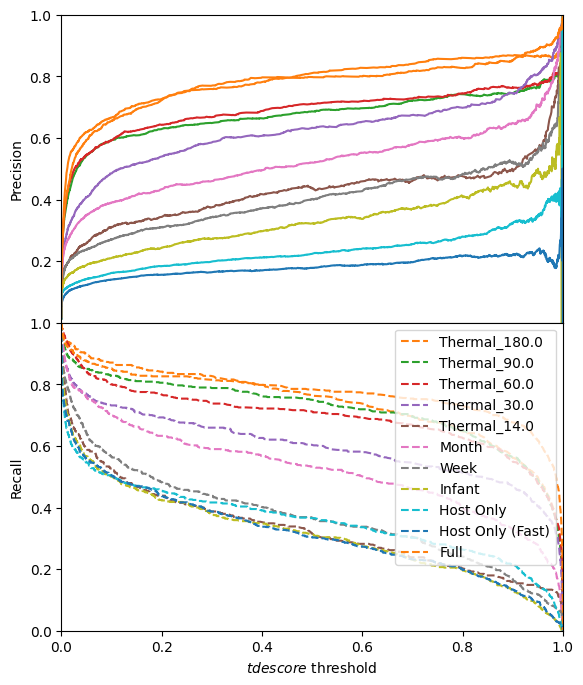

In [13]:
fscale = 4.
figsize=(fscale*1.618, 2*fscale)

plt.figure(figsize=figsize)

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

keys = list(param_res.keys())[::-1]

for i, key in enumerate(keys):
    (pr, recall, thresholds) = param_res[key]
    c = f"C{i+1}"
    lab = labels[::-1][i]
    ax1.plot(thresholds[:-1], pr[1:-1], color=c)
    ax2.plot(thresholds[:-1], recall[1:-1], label=lab, color=c, linestyle="--")
    
for ax in [ax1, ax2]:    
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)

ax1.set_ylim(0.0, 0.3)

ax2.legend()
ax2.set_xlabel(r"$\it{tdescore}$ threshold")
ax1.set_ylabel("Precision")
ax2.set_ylabel("Recall")

ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

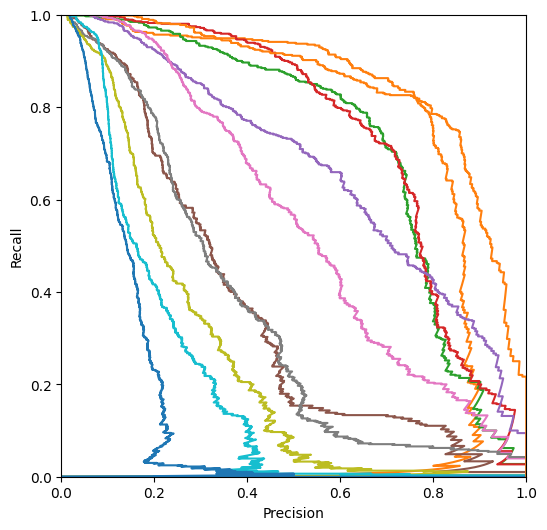

In [14]:
figsize=(1.5*fscale, 1.5*fscale)
plt.figure(figsize=figsize)
for i, key in enumerate(keys):
    (pr, recall, thresholds) = param_res[key]
    c = f"C{i+1}"
    lab = labels[::-1][i]
    plt.plot(pr, recall, label=lab, c=c)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
# plt.legend()
# plt.savefig("figures/precision_recall_comparison.pdf", bbox_inches='tight')
plt.show()

In [15]:
text_str = r"""\begin{table*}[]
        \begin{tabular}{c|c|c|c|c}
        \textbf{Parameter Set} & \textbf{New Parameters} & \textbf{Total Parameters} & \textbf{ROC Area} & \textbf{Precision/Recall Area} \\
        \hline
"""
print(text_str)

used_parameters = []

for i, row in param_df.iterrows():
    relevant_columns, column_descriptions = parse_columns(all_features[i])
    relevant_columns = [x for x in relevant_columns if x not in used_parameters]
    name = relevant_columns[0].replace('_', '\_')
    print("\t" + r" \textbf{" + row[0] + r"}" +f" & {name} & {row[1]} & {row[2]:.2f} & {row[3]:.2f} \\\\")
    for x in relevant_columns[1:]:
        name = x.replace('_', '\_')
        print(f"\t & {name} &  &  & \\\\")
        
    used_parameters += relevant_columns
        
    print("\t \hline")
print(r"\end{tabular}")
print(r"\caption{Performance of \tdes for four parameter sets: information only about the host, information available shortly after discovery, information available by the time of peak, and the full parameter set. The performance of \tdes substantially with more data, but high performance is only achieved for the full dataset.}")
print(r"""\label{tab:parameter_subset}
\end{table*}""")
    

\begin{table*}[]
        \begin{tabular}{c|c|c|c|c}
        \textbf{Parameter Set} & \textbf{New Parameters} & \textbf{Total Parameters} & \textbf{ROC Area} & \textbf{Precision/Recall Area} \\
        \hline

	 \textbf{Full} & w1\_m\_w2 & 39 & 0.99 & 0.85 \\
	 & w3\_m\_w4 &  &  & \\
	 & w1\_chi2 &  &  & \\
	 & sgscore1 &  &  & \\
	 & has\_milliquas &  &  & \\
	 & g-r\_MeanPSFMag &  &  & \\
	 & r-i\_MeanPSFMag &  &  & \\
	 & i-z\_MeanPSFMag &  &  & \\
	 & z-y\_MeanPSFMag &  &  & \\
	 & strm\_prob\_Galaxy &  &  & \\
	 & strm\_prob\_Star &  &  & \\
	 & strm\_prob\_QSO &  &  & \\
	 & gaia\_aplx &  &  & \\
	 & infant\_n\_detections &  &  & \\
	 & infant\_has\_g &  &  & \\
	 & infant\_has\_r &  &  & \\
	 & week\_g\_rise &  &  & \\
	 & week\_r\_rise &  &  & \\
	 & week\_median\_color &  &  & \\
	 & peak\_color &  &  & \\
	 & det\_cadence &  &  & \\
	 & y\_scale &  &  & \\
	 & color\_grad &  &  & \\
	 & pre\_inflection &  &  & \\
	 & sncosmo\_chisq &  &  & \\
	 & sncosmo\_chi2pdof &  &  & \\
	

IndexError: list index out of range

In [ ]:
explain = "Thermal_14.0"

idx = labels.index(explain)
print(idx)

# importance_idx = 2

relevant_columns, column_descriptions = parse_columns(all_features[idx])
clf = saved_clfs[explain]

features = pd.DataFrame([relevant_columns, column_descriptions, list(clf.feature_importances_), ]).T
features.sort_values(by=2, ascending=False, inplace=True)
features

In [ ]:
clfs.keys()

In [ ]:
plt.hist(full_info_sources["high_noise"])

In [ ]:
full_info_sources["noise"] > 0.104